In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


import sys
#import PhiFlow
import argparse
from collections import OrderedDict
import datetime
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pylab as plt
from numbers import Number
import numpy as np
import pandas as pd
import gc
pd.options.display.max_rows = 1500
pd.options.display.max_columns = 200
pd.options.display.width = 1000
pd.set_option('max_colwidth', 400)
import pdb
import pickle
import pprint as pp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from deepsnap.batch import Batch as deepsnap_Batch
#from plasma.uncertainty_toolbox import uct
#import plasma.uncertainty_toolbox as uct
from le_pde_uq.uncertainty_toolbox.metrics import root_mean_squared_calibration_error, mean_absolute_calibration_error, miscalibration_area
from le_pde_uq.uncertainty_toolbox.viz import plot_intervals_ordered, plot_calibration, plot_sharpness
from le_pde_uq.uncertainty_toolbox.metrics_calibration import sharpness
import pprint as pp


import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from le_pde_uq.argparse1 import arg_parse
from le_pde_uq.datasets.load_dataset import load_data
from le_pde_uq.models import load_model, rollout
from le_pde_uq.pytorch_net.util import Batch, get_tril_block, get_triu_block, get_unique_keys_df, filter_df, groupby_add_keys, Printer, get_num_params, get_machine_name, pload, pdump, to_np_array, get_pdict, reshape_weight_to_matrix, ddeepcopy as deepcopy, plot_vectors, record_data, filter_filename, Early_Stopping, str2bool, get_filename_short, print_banner, plot_matrices, get_num_params, init_args, filter_kwargs, to_string, COLOR_LIST
from le_pde_uq.datasets.hyperparam import update_legacy_default_hyperparam
from le_pde_uq.utils import loss_op_core, requires_grad, get_prioritized_dropout, MLP, LpLoss, to_cpu, to_tuple_shape, parse_multi_step, loss_op, get_cholesky_inverse, get_device, get_data_comb
EXP_PATH="results/"
device = torch.device("cuda:0")
p = Printer()

Cannot import dolfin. If dolfin is not needed, please ignore this message.


## 0. Functions:

In [2]:
def plot_learning_curve(data_record):
    x_axis = np.arange(len(data_record["train_loss"]))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(x_axis, data_record["train_loss"], label="train")
    plt.plot(x_axis, data_record["val_loss"], label="val")
    plt.plot(x_axis, data_record["test_loss"], label="test")
    plt.legend()
    plt.subplot(1,2,2)
    plt.semilogy(x_axis, data_record["train_loss"], label="train")
    plt.semilogy(x_axis, data_record["val_loss"], label="val")
    plt.semilogy(x_axis, data_record["test_loss"], label="test")
    plt.legend()
    plt.show()

In [3]:
def get_results_2d(all_hash, mode=-1, suffix=""):
    all_dict = {}
    df_dict_list = []
    isplot = True
    for hash_str in all_hash:
        # Load model:
        dirname = EXP_PATH + "anonymous-uncertainty_2023-08-19/"
        df_dict = {}

        filename = filter_filename(dirname, include=hash_str)
        if len(filename) == 0:
            dirname = dirname = EXP_PATH + "anonymous-uncertainty_2023-08-19/"
            filename = filter_filename(dirname, include=hash_str)
            if len(filename) == 0:
                print(f"hash {hash_str} does not exist!")
                continue

        try:
            data_record = pload(dirname + filename[0])
        except Exception as e:
            print(f"error {e}")
            continue
        if "train_loss" not in data_record:
            continue
        if isplot:
            plot_learning_curve(data_record)
        args = init_args(update_legacy_default_hyperparam(data_record["args"]))
        args.filename = filename
        if mode == "best":
            model = load_model(data_record["best_model_dict"], device=device)
            print("Load the model with best validation loss.")
        else:
            assert isinstance(mode, int)
            print(f'Load the model at epoch {data_record["epoch"][mode]}')
            model = load_model(data_record["model_dict"][mode], device=device)
        model.eval()
        p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=100)

        # Load test dataset:
        args_test = deepcopy(args)
        if args.temporal_bundle_steps == 1:
            if args.dataset in ["fno", "fno-2", "fno-3"]:
                args_test.multi_step = "20"
            elif args.dataset in ["fno-1"]:
                args_test.multi_step = "40"
            elif args.dataset in ["fno-4"]:
                args_test.multi_step = "10"
            else:
                raise
        else:
            pass
        args_test.batch_size = 20
        (dataset_train_val, dataset_test), (train_loader, val_loader, test_loader) = load_data(args_test)
        myloss = LpLoss(size_average=False)

        # Compute loss:
        loss_list = []
        pred_list = []
        y_list = []
        for data in dataset_test:
            data.to(device)
            preds, info = model(
                data,
                pred_steps=np.arange(1,int(args_test.multi_step)+1),
                latent_pred_steps=None,
                is_recons=False,
                use_grads=False,
                is_y_diff=False,
                is_rollout=False,
                use_pos=args.use_pos,
            )
            pred_reshape = preds["n0"].reshape(1,-1)
            y_reshape = data.node_label["n0"].reshape(1,-1)
            pred_list.append(preds["n0"].detach())
            y_list.append(data.node_label["n0"].detach())
            loss_ele = myloss(pred_reshape, y_reshape)
            loss_list.append(loss_ele.item())
        loss_mean = np.mean(loss_list)
        pred_list = torch.stack(pred_list).squeeze(-1)
        y_list = torch.stack(y_list).squeeze(-1)
        all_dict[hash_str] = (data_record['best_epoch'], loss_mean, len(data_record["train_loss"]), args.epochs)
        print(all_dict[hash_str])
        print("Test for {} is: {:.6e} at epoch {}".format(hash_str, loss_mean, data_record['best_epoch']))

        # df_dict:
        df_dict["loss"] = loss_mean
        df_dict.update(args.__dict__)
        df_dict["hash_str"] = hash_str
        df_dict["train_loss"] = data_record["train_loss"][-1]
        df_dict["val_loss"] = data_record["val_loss"][-1]
        df_dict["test_loss"] = data_record["test_loss"][-1]
        df_dict["epoch"] = data_record["epoch"][-1]
        df_dict_list.append(df_dict)

        # Plotting:
        pred_reshape = preds["n0"].permute(1,0,2).squeeze(-1)
        y_reshape = data.node_label["n0"].permute(1,0,2).squeeze(-1)
        loss_ele = myloss(pred_reshape, y_reshape)
        num = 10
        print("loss_cumu:")
        mse_full = nn.MSELoss(reduction="none")(pred_list, y_list)
        mse_time = to_np_array(mse_full.mean((0,1)))
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(mse_time)
        plt.xlabel("rollout step")
        plt.ylabel("MSE")
        plt.title("MSE vs. rollout step (linear scale)")
        plt.subplot(1,2,2)
        plt.semilogy(mse_time)
        plt.xlabel("rollout step")
        plt.ylabel("MSE")
        plt.title("MSE vs. rollout step (log scale)")
        plt.show()

        print("individual:")
        for i in range(len(pred_reshape) // num):
            print("pred:")
            plot_matrices(pred_reshape[num*i:num*(i+1)].reshape(num, 64, 64), images_per_row=num, scale_limit="auto")
            print("y:")
            plot_matrices(y_reshape[num*i:num*(i+1)].reshape(num, 64, 64), images_per_row=num, scale_limit="auto")
            print("diff:")
            plot_matrices((pred_reshape - y_reshape)[num*i:num*(i+1)].reshape(num, 64, 64), images_per_row=num, scale_limit="auto")
    pdump(all_dict, f"all_dict_2d{suffix}.p")
    df = pd.DataFrame(df_dict_list)

In [110]:
def plot_rollout(pred_mean, pred_unc_scale, y, idx_list):
    """
    pred_mean, pred_unc_scale, y: all have shape of [B,4096,time_steps]
    idx_list: the id in a batch
    """
    if isinstance(pred_mean, np.ndarray):
        pred_mean = torch.tensor(pred_mean)
        pred_unc_scale = torch.tensor(pred_unc_scale)
        y = torch.tensor(y)
    if not isinstance(idx_list, list):
        idx_list = [idx_list]
    for idx in idx_list:
        print(f"idx: {idx}")
        if isinstance(idx, np.ndarray) or isinstance(idx, list):
            pred_reshape = pred_mean[idx].squeeze(-1)
            y_reshape = y[idx].squeeze(-1)
            pred_unc_scale_reshape = pred_unc_scale[idx].squeeze(-1)
        else:
            pred_reshape = pred_mean[idx].transpose(1,0)
            y_reshape = y[idx].transpose(1,0)
            pred_unc_scale_reshape = pred_unc_scale[idx].transpose(1,0)
        for i in range(int(np.ceil(len(pred_reshape) / num))):
            plot_num=min(num, y_reshape.shape[0])
            l2loss = LpLoss(size_average=False)(pred_reshape.reshape(1,-1), y_reshape.reshape(1,-1))
            print("ground-truth:")
            plot_matrices(y_reshape[num*i:num*(i+1)].reshape(-1, 64, 64),
                          images_per_row=num, #scale_limit="auto",
                          is_balanced=True, cmap="jet",
                          no_xlabel=True,
                         )
            print("prediction L2={:.6f}:".format(l2loss.item()))
            plot_matrices(pred_reshape[num*i:num*(i+1)].reshape(-1, 64, 64),
                          images_per_row=num,# scale_limit="auto",
                          is_balanced=True, cmap="jet",
                          no_xlabel=True,
                         )
            # print("diff:")
            # plot_matrices((pred_reshape - y_reshape)[num*i:num*(i+1)].reshape(num, 64, 64),
            #               images_per_row=num, scale_limit="auto",
            #               is_balanced=True, cmap="PiYG",
            #              )

            abs_error = (pred_reshape - y_reshape).abs()[num*i:num*(i+1)].reshape(-1, 64, 64)
            max_val = torch.maximum(torch.quantile(abs_error.reshape(-1), 0.997), torch.quantile(pred_unc_scale.reshape(-1), 0.997)).item()
            print(f"abs error: scale [0, {max_val:.3f}]")

            plot_matrices(abs_error,
                          images_per_row=num, scale_limit=(0, max_val),
                          is_balanced=False, cmap="jet",
                          no_xlabel=True,
                         )
            print("uncertainty_scale: same scale as abs error")

            plot_matrices(pred_unc_scale_reshape.reshape(-1, 64, 64),
                          images_per_row=num, scale_limit=(0, max_val),
                          is_balanced=False, cmap="jet",
                          no_xlabel=True,
                         )

        mace = uct.mean_absolute_calibration_error(flatten(pred_reshape), flatten(pred_unc_scale_reshape), flatten(y_reshape))
        rmsce = uct.root_mean_squared_calibration_error(flatten(pred_reshape), flatten(pred_unc_scale_reshape), flatten(y_reshape))
        ma = uct.miscalibration_area(flatten(pred_reshape), flatten(pred_unc_scale_reshape), flatten(y_reshape))

        make_plots_2d(flatten(pred_reshape), flatten(pred_unc_scale_reshape), flatten(y_reshape))


def make_plots_2d(pred_mean, pred_std, y):
    """Make set of plots."""

    ylims = [-3, 3]
    n_subset = 50

    fig, axs = plt.subplots(1, 2, figsize=(17, 7))

    # # Make xy plot
    # axs[0] = uct.plot_xy(
    #     pred_mean, pred_std, y, x, n_subset=300, ylims=ylims, xlims=[0, 15], ax=axs[0]
    # )

    # Make ordered intervals plot
    axs[0] = uct.plot_intervals_ordered(
        pred_mean, pred_std, y, n_subset=n_subset, ylims=ylims, ax=axs[0]
    )

    # Make calibration plot
    axs[1] = uct.plot_calibration(pred_mean, pred_std, y, ax=axs[1])

    # Adjust subplots spacing
    fig.subplots_adjust(wspace=0.25)

    
def flatten(tensor):
    return to_np_array(tensor).reshape(-1)


def get_metrics(pred_mean, pred_std, y, metrics="all", verbose=True):
    pred_mean_flatten = flatten(pred_mean)
    pred_std_flatten = flatten(pred_std)
    y_flatten = flatten(y)
    metrics_dict = {}
    if metrics == "all":
        metrics = ["l2", "mae", "mean-std",
                   "mace", "rmsce", "ma",
                   "sharp",
                  ]
    for metric in metrics:
        if metric == "l2":
            metrics_dict[metric] = LpLoss(size_average=True)(torch.tensor(pred_mean).flatten(start_dim=1),
                                                              torch.tensor(y).flatten(start_dim=1)).item()
        elif metric == "mae":
            metrics_dict[metric] = (torch.tensor(pred_mean).reshape(1,-1) - torch.tensor(y).reshape(1,-1)).abs().mean().item()
        elif metric == "mean-std":
            metrics_dict[metric] = pred_std.mean().item()
        elif metric == "mace":
            metrics_dict[metric] = uct.mean_absolute_calibration_error(pred_mean_flatten, pred_std_flatten, y_flatten)
        elif metric == "rmsce":
            metrics_dict[metric] = uct.root_mean_squared_calibration_error(pred_mean_flatten, pred_std_flatten, y_flatten)
        elif metric == "ma":
            metrics_dict[metric] = uct.miscalibration_area(pred_mean_flatten, pred_std_flatten, y_flatten)
        elif metric == "sharp":
            metrics_dict[metric] = uct.sharpness(pred_std_flatten)
        else:
            raise
    if verbose:
        pp.pprint(metrics_dict)
    return metrics_dict

## 1. Analysis

### 1.0 Hashes:

In [9]:
###########################################################################
# Enter a list of hashes for the experiment to analyze:
###########################################################################

all_hash = ["6CtYPnsb", "PDVgajFB", "yIY7taZW", "3IxOONNa", "VZqQsGda", "LguEpNzs", "8etxnfKG"]
all_hash = ["Pam1F5FD",
            # "wvRPm+3E",
            # "XGsaOjWE",
            # "eJW6SCBK",
            # "2GiiVeUQ",
           ]
# all_hash = ["NSfcFSO5", "2GiiVeUQ", "Lvdn+dA9", "8aDHBLDN", "chP9lDcT", "UaNaIG5X", "+FfGIK0b", "fGZv9pAa", "9npDBhOy", "JnCMGkjb", "F0Najp5A", "sEOpl9Ob", "mdMYZB09", "KcZIVBtv"]
# all_hash = ["7TCXqHp8", "T024z6bP"]
# all_hash = ["9npDBhOy"]
# all_hash = ["9hKxD11e"]
all_hash = [
    "Lvdn+dA9"
]
all_hash = [
    "dkKJGWbP_turing2",
    "kLPUUj3X_turing2",
    "LZuDWCqi_turing2",
]
all_hash = [
    "IkMrbgt8",
]
all_hash = [
    "IkMrbgt8_turing2",
]
all_hash = [
    "Lvdn+dA9",
    # "kLPUUj3X_turing2",
]
all_hash = [
    "VzXIzNvw",
    "uGySZ8O+",
    
]
all_hash = [
    "Rk0XiYjW_turing2",
    "xm2Xmh",
]
all_hash = [
    
    "MM8nvPFZ_turing2"
]
all_hash = [ # fno1
    "cTn7pKa_turing2",
    "vNoP4_turing2",
    "Nop15xa5_turing2",
    "IkMrbgt8_turing2",
    
]
all_hash = [ # fno3
    "tcFnLuh4_turing2",
    "24kRn0qn_turing2",
    "45ZnhuX4_turing2",
    "DfDJycJe_turing2",
    "eo5Y84s_turing2",
    "x9lN06bf_turing2",
    
]
all_hash = [
    "Lvdn+dA9_turing2",
    "ECshE1x1_turing2",
    "2o9axpaz_turing2",
    "QLkuuTf9_turing2",
    "hXzEAQeu_turing2",
    "nG2NBRJH_turing2",
    "A5MW+aSX_turing2",
    "JPfumADS_turing2",
    "NnADtSwi_turing2",
    "RgaOa9tD_turing2",
    
    
]
all_hash = [
    "eod5Bsi0_turing2"
]
isplot = True
all_hash = [ # fno3
    "eo5Y84s_turing2",
    "x9lN06bf_turing2",
]
all_hash = [
    # "cTn7pKa_turing2",
    "pk+vNoP4_turing2",
    # "Nop15xa5_turing2",
    # "IkMrbgt8_turing2",
    # "ajTxNaYP_turing2",
    
]
all_hash = [ # final
    "DfDJycJe_turing2"
]
all_hash = [
    "GbEU4AC8",
]
all_hash = [
    "1j2nLeOn_turing2"
]

all_hash = [
    "9npDBhOy_turing2"
]
all_hash = [
    # "YkILg8wB_turing2"
    # "ck3kAARM_turing2",
    "Hash_76ejOwCq_turing2"
]
all_hash = [
    "pk+vNoP4_turing2",
]
all_hash = [
    # "pJNjry6K_turing2",# recons_coef=0
    # "BUU7V+A3_turing2", # --is_pretrain_autoencode=True --epochs_pretrain=100
    # "an+3Vjyd_turing2", # --is_pretrain_autoencode=True --epochs_pretrain=50
    "shfyHjIC_turing2", # --is_pretrain_autoencode=True --epochs_pretrain=25
    
]
all_hash = [
    "GDFQaIxl_turing2", # Standard
    "pxaPofkM_turing2", # NeuralBasis, rational
    "zO7Gol0z_turing2", # NeuralBasis, elu
    "9ia59MGA_turing2", # NeuralBasis, siren
]

### 1.1 New exp:

### 1.2 Uncertainty:

In [112]:
dirname = EXP_PATH + "anonymous-uncertainty_2023-08-19/"
filenames = filter_filename(dirname, include=[])
all_hash = ["_".join(filename.split("_")[-2:])[:-2] for filename in filenames if len(filename.split("_")) > 2 and "3rd_new" in filename]

# all_hash = [
#     # "wWFn3M8B_turing3",
#     # "IHBAY0DL_turing3",
#     "DVStNzT7_turing1",
#     "WL8K0t6A_turing1", 
# ]

all_hash = [
    "UKYe4IN6_turing1",
]
all_hash = [
    # "pJ+SvFXC_turing3",
    # "cqYbtq99_turing3",
    # "yyVYNMPg_turing3",
    # "A5XoGgoH_turing3",
    # "2U3XOE+u_turing3",
    # "bcja0G3a_turing3",
    # "jjNyaOr0_turing3",
    # "ZNuVhzDc_turing3",
    # "gJHhwmwR_turing3",
    # "8ugDalen_turing3",
    # "19iyjspl_turing3",
    # "V8kHTPos_turing3",
    # "laa9UZev_turing3",
    # "dOh+6zwG_turing3",
    # "l7Rw7Wvv_turing3",
    # "hypx31zj_turing3",
    # "qLcco4RU_turing3",
    # "4nahWQ3V_turing4",
    # "4V76iFzF_turing4"
]
all_hash = [
    "1MWsWgeM_turing3",
    "rD5e767k_turing3"
]
all_hash= ["H5yGgSzf_turing3"]

#### 1.2.2 Uncertainty for dropout:

In [54]:
dirname = EXP_PATH + "anonymous-uncertainty_2023-08-19/"
filenames = filter_filename(dirname, include=[])
all_hash = ["_".join(filename.split("_")[-2:])[:-2] for filename in filenames if len(filename.split("_")) > 2 and "3rd_new" in filename]

all_hash = [
    "eoX4Sg0u_turing3",
    "aiwDflLO_turing3",
    "khcOH0qw_turing3",
    "vaJTw89Y_turing3",
    "sDbZL7OM_turing3",
]

In [56]:
all_dict.keys()

dict_keys(['eoX4Sg0u_turing3', 'aiwDflLO_turing3', 'khcOH0qw_turing3', 'vaJTw89Y_turing3', 'sDbZL7OM_turing3'])

In [65]:
all_dict['vaJTw89Y_turing3']["unc_metrics"]

{'l2': 0.3533538281917572,
 'mae': 0.34280848503112793,
 'mean-std': 0.09484852850437164,
 'mace': 0.32476991333007815,
 'rmsce': 0.37038731566153077,
 'ma': 0.3280504175051296,
 'sharp': 0.10824202}

In [58]:
key = 'aiwDflLO_turing3'

In [61]:
all_dict[key]["y_list"].shape

torch.Size([200, 4096, 10])

idx: -1
y:


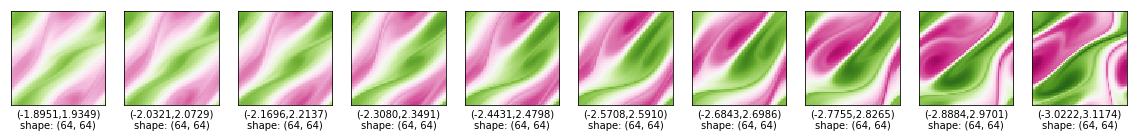


prediction L2=0.150213:


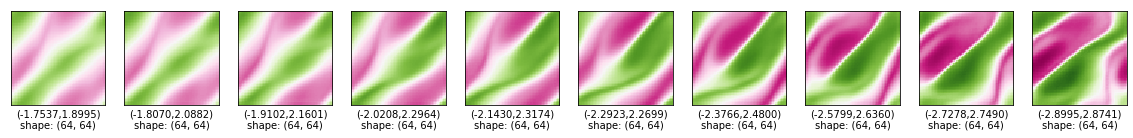


abs error:


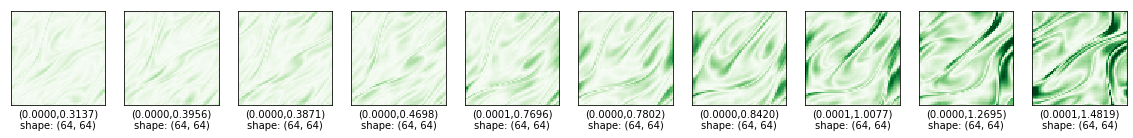


uncertainty_scale:


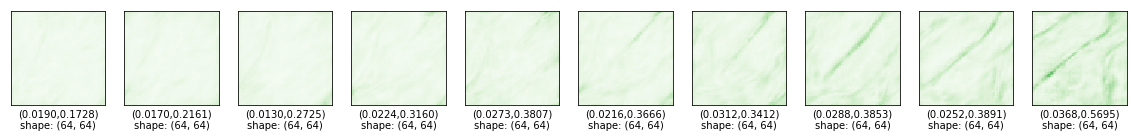

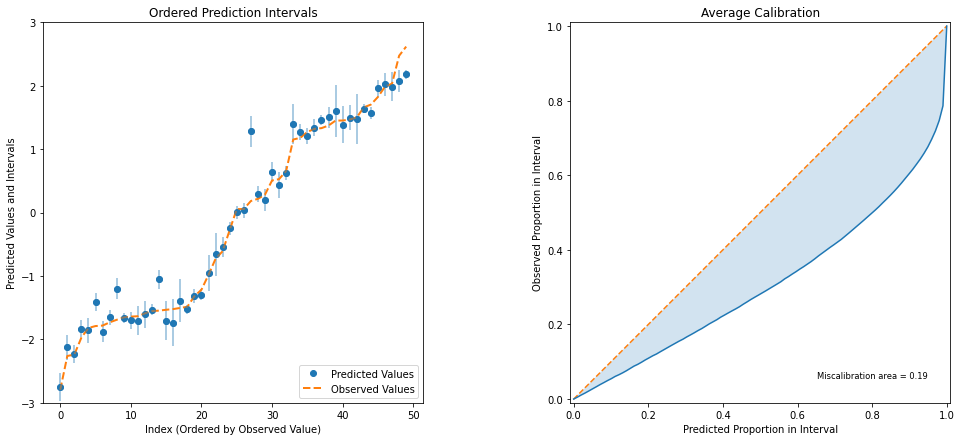

In [62]:
plot_rollout(all_dict[key]["pred_list"], all_dict[key]["pred_ls_list"].exp(), all_dict[key]["y_list"], idx_list=-1)

### 1.3 Analysis of uncertainty:

In [129]:
dirname = EXP_PATH + "anonymous-uncertainty_2023-08-19/"
filenames = filter_filename(dirname, include=[])
# include = "rD5e767k_turing3"
include = "3rd_new"
date_time = "2022-10-17"

# include = "4th_new"
# date_time = "2022-10-18"

# date_time = "{}-{}-{}".format(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day)
all_hash = ["_".join(filename.split("_")[-2:])[:-2] for filename in filenames if len(filename.split("_")) > 2 and include in filename]

In [130]:
df_dict_list = []
isplot = True
is_single_step = False
is_unc_metrics = False
id = include
all_dict_filename = f"all_dict_{date_time}_sing_{is_single_step}_id_{id}.p"

In [131]:
all_dict = pload(all_dict_filename)

In [128]:
pred_loc = torch.stack([all_dict[key]["pred_list"] for key in all_dict])
pred_ls = torch.stack([all_dict[key]["pred_ls_list"] for key in all_dict])
y_loc = all_dict[next(iter(all_dict))]["y_list"]
pred_scale = pred_ls.exp()
# assert len(pred_loc) >= 10
pred_loc_indi = pred_loc[0]
pred_loc_ensemble = pred_loc.mean(0)
pred_scale_det_ensemble = (pred_loc.square().mean(0) - pred_loc.mean(0).square()).sqrt()
pred_scale_indi_ensemble = pred_scale[0]
pred_scale_full_ensemble = ((pred_loc.square() + pred_scale.square()).mean(0) - pred_loc.mean(0).square()).sqrt()

metrics = "all" # ["l2","mae","mean-std"]
all_metrics = {
    "full": get_metrics(pred_loc_ensemble, pred_scale_full_ensemble,  y_loc, metrics=metrics),
    "indi": get_metrics(pred_loc_indi, pred_scale_indi_ensemble,  y_loc, metrics=metrics),
    "det":  get_metrics(pred_loc_ensemble, pred_scale_det_ensemble,  y_loc, metrics=metrics),
}
pdump(all_metrics, f"all_metrics_{str(metrics)}" + all_dict_filename[11:])
# plot_rollout(pred_loc_ensemble, pred_scale_full_ensemble, y_loc, idx_list=-1)
# plot_rollout(pred_loc_indi, pred_scale_indi_ensemble, y_loc, idx_list=-1)

<ipython-input-110-ad00aacb874c>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metrics_dict[metric] = LpLoss(size_average=True)(torch.tensor(pred_mean).flatten(start_dim=1),
<ipython-input-110-ad00aacb874c>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y).flatten(start_dim=1)).item()
<ipython-input-110-ad00aacb874c>:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metrics_dict[metric] = (torch.tensor(pred_mean).reshape(1,-1) - torch.tensor(y).reshape(1,-1)).abs().mean().item()


{'l2': 0.15621158480644226,
 'ma': 0.010142229850563235,
 'mace': 0.01004082031250004,
 'mae': 0.1295509785413742,
 'mean-std': 0.15862895548343658,
 'rmsce': 0.012373273898946562,
 'sharp': 0.23497073}
{'l2': 0.16523446142673492,
 'ma': 0.10476842460252822,
 'mace': 0.10372074218750002,
 'mae': 0.13969837129116058,
 'mean-std': 0.13559162616729736,
 'rmsce': 0.11612707450926633,
 'sharp': 0.21648817}
{'l2': 0.15621158480644226,
 'ma': 0.2283412968812898,
 'mace': 0.22605789672851567,
 'mae': 0.1295509785413742,
 'mean-std': 0.06555377691984177,
 'rmsce': 0.25462503654600427,
 'sharp': 0.08955049}


In [22]:
myloss(pred_reshape, y_reshape)

tensor(1.1849, device='cuda:3', grad_fn=<SumBackward0>)

In [19]:
all_metrics = {
    # "full": get_metrics(pred_loc_ensemble, pred_scale_full_ensemble,  y_loc, metrics=["l2","mae","mean-std"]),
    "indi": get_metrics(pred_loc_indi, pred_scale_indi_ensemble,  y_loc, metrics="all"),
    # "det":  get_metrics(pred_loc_ensemble, pred_scale_det_ensemble,  y_loc, metrics=["l2","mae","mean-std"]),
}

{'l2': 0.2409292608499527,
 'ma': 0.0444925660412722,
 'mace': 0.044047640380859426,
 'mae': 0.20509323477745056,
 'mean-std': 0.2496117204427719,
 'rmsce': 0.050015194432386986,
 'sharp': 0.3832859}


In [27]:
LpLoss(size_average=True)(pred_loc_indi.flatten(start_dim=1), y_loc.flatten(start_dim=1))

tensor(0.2345, device='cuda:3')

### 1.4 Inverse problem:

In [70]:
dirname = EXP_PATH + "anonymous-uncertainty_2023-08-19/"
filenames = filter_filename(dirname, include=[])
include = "3rd_new"
date_time = "2022-10-17"

include = "4th_new"
date_time = "2022-10-18"

id = include
all_hash = ["_".join(filename.split("_")[-2:])[:-2] for filename in filenames if len(filename.split("_")) > 2 and include in filename]

In [29]:
collate_fn = deepsnap_Batch.collate()
dataset_test.to("cpu")
test_loader = DataLoader(dataset_test, collate_fn=collate_fn, 
                         batch_size=20, shuffle=False, drop_last=True)

In [30]:
for i, data in enumerate(test_loader):
    pass
data_k = deepcopy(data)

In [64]:
uct.viz.set_style()
uct.viz.update_rc("text.usetex", False)  # Set to True for system latex
uct.viz.update_rc("font.size", 5)  # Set font size
uct.viz.update_rc("xtick.labelsize", 14)  # Set font size for xaxis tick labels
uct.viz.update_rc("ytick.labelsize", 14)  # Set font size for yaxis tick labels

# plot_matrices(data_k.node_feature["n0"].squeeze(-1).permute(1,0).reshape(10,64,64), 
#     images_per_row=20,
#     is_balanced=True, cmap="PiYG",
# )
# plot_matrices(data_k.node_label["n0"].squeeze(-1).permute(1,0).reshape(10,64,64), 
#     images_per_row=20,
#     is_balanced=True, cmap="PiYG",
# )

In [71]:
all_dict_inverse = pload(f"all_dict_inverse_{date_time}_sing_{is_single_step}_id_{id}.p")

In [68]:
init_loc = np.stack([all_dict_inverse[key]["recons"] for key in all_dict_inverse]).reshape(10,20,-1,1)
init_scale = np.stack([all_dict_inverse[key]["recons_std"] for key in all_dict_inverse]).reshape(10,20,-1,1)
init_gt = np.stack([all_dict_inverse[key]["init_gt"][:,-1:] for key in all_dict_inverse]).reshape(10,20,-1,1)[0]
init_loc_ensemble = init_loc.mean(0)
init_scale_det_ensemble = np.sqrt((init_loc**2).mean(0) - init_loc.mean(0)**2)
init_loc_indi = init_loc[0]
init_scale_indi_ensemble = init_scale[0]
init_scale_full_ensemble = np.sqrt((init_loc**2 + init_scale**2).mean(0) - init_loc.mean(0)**2)

In [72]:
# For no latent:
init_loc = np.stack([all_dict_inverse[key]["init"][:,-1:] for key in all_dict_inverse]).reshape(10,20,-1,1)
# init_scale = np.stack([all_dict_inverse[key]["recons_std"] for key in all_dict_inverse]).reshape(10,20,-1,1)
init_gt = np.stack([all_dict_inverse[key]["init_gt"][:,-1:] for key in all_dict_inverse]).reshape(10,20,-1,1)[0]
init_loc_ensemble = init_loc.mean(0)
init_scale_det_ensemble = np.sqrt((init_loc**2).mean(0) - init_loc.mean(0)**2)
# init_loc_indi = init_loc[0]
# init_scale_indi_ensemble = init_scale[0]
# init_scale_full_ensemble = np.sqrt((init_loc**2 + init_scale**2).mean(0) - init_loc.mean(0)**2)

In [69]:
all_metrics = {
    "full": get_metrics(init_loc_ensemble, init_scale_full_ensemble,  init_gt, metrics=["l2","mae","mean-std"]),
    "indi": get_metrics(init_loc_indi, init_scale_indi_ensemble,  init_gt, metrics=["l2","mae","mean-std"]),
    "det": get_metrics(init_loc_ensemble, init_scale_det_ensemble,  init_gt, metrics=["l2","mae","mean-std"]),
}
# pdump(all_metrics, "all_metrics_inverse_" + all_dict_filename[11:])

{'l2': 0.186319500207901,
 'mae': 0.15053264796733856,
 'mean-std': 0.2503124475479126}
{'l2': 0.25476542115211487,
 'mae': 0.20452003180980682,
 'mean-std': 0.11876358091831207}
{'l2': 0.186319500207901,
 'mae': 0.15053264796733856,
 'mean-std': 0.1845858246088028}


idx: [0 1 2 3 4 5 6 7 8 9]
y:


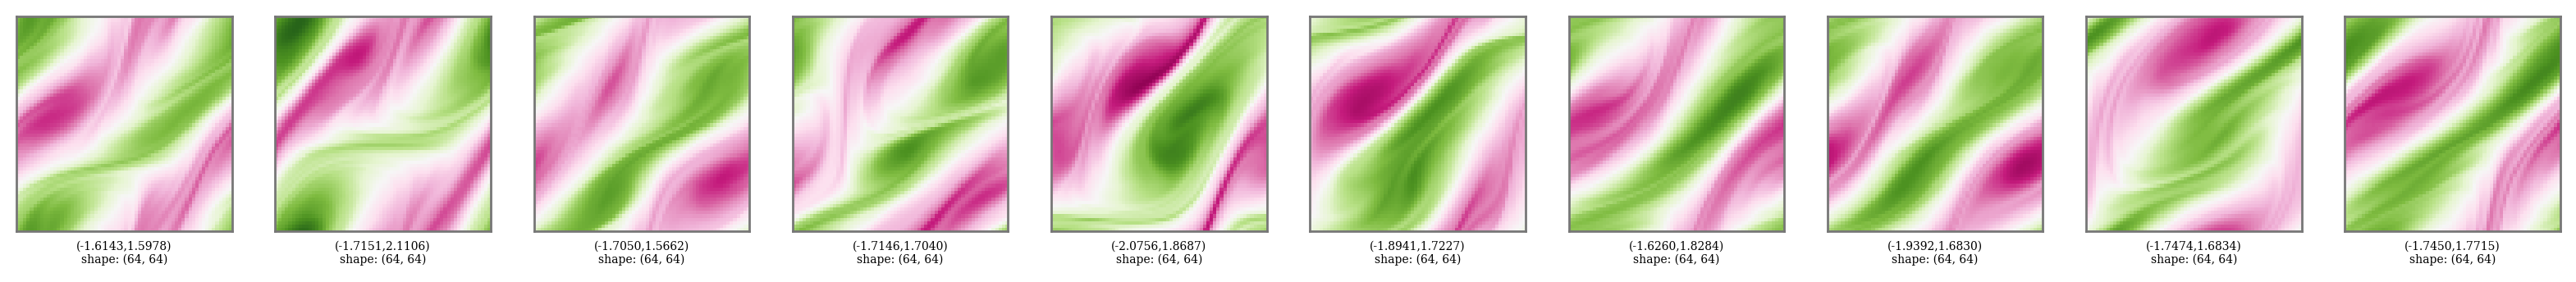


prediction L2=0.191967:


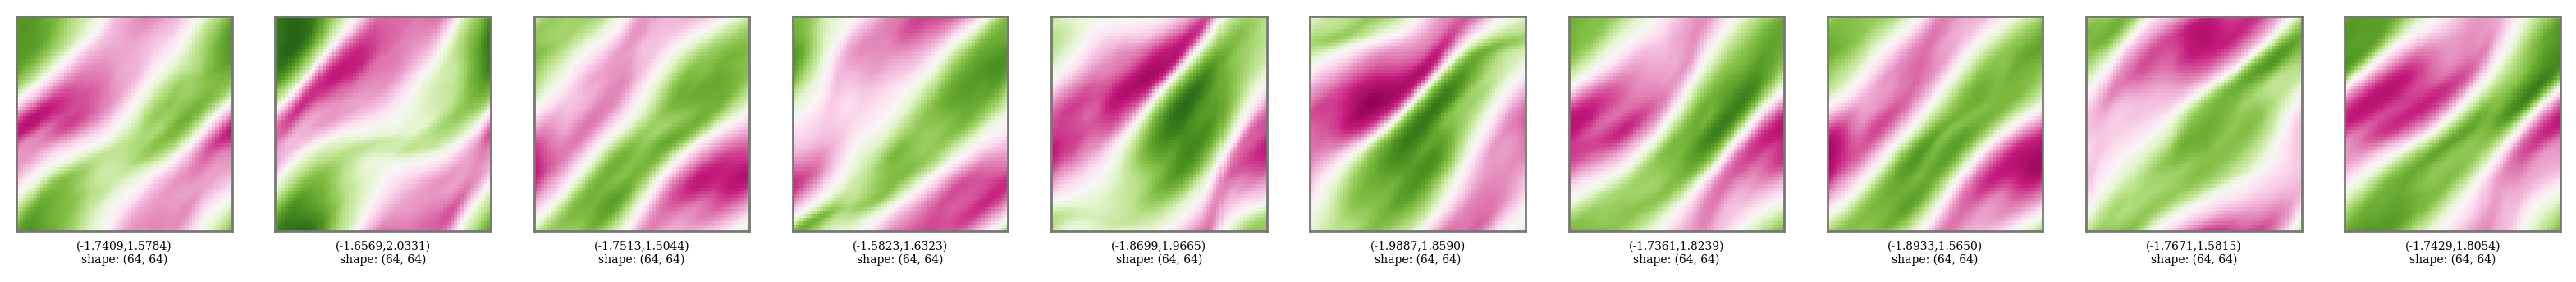


abs error:


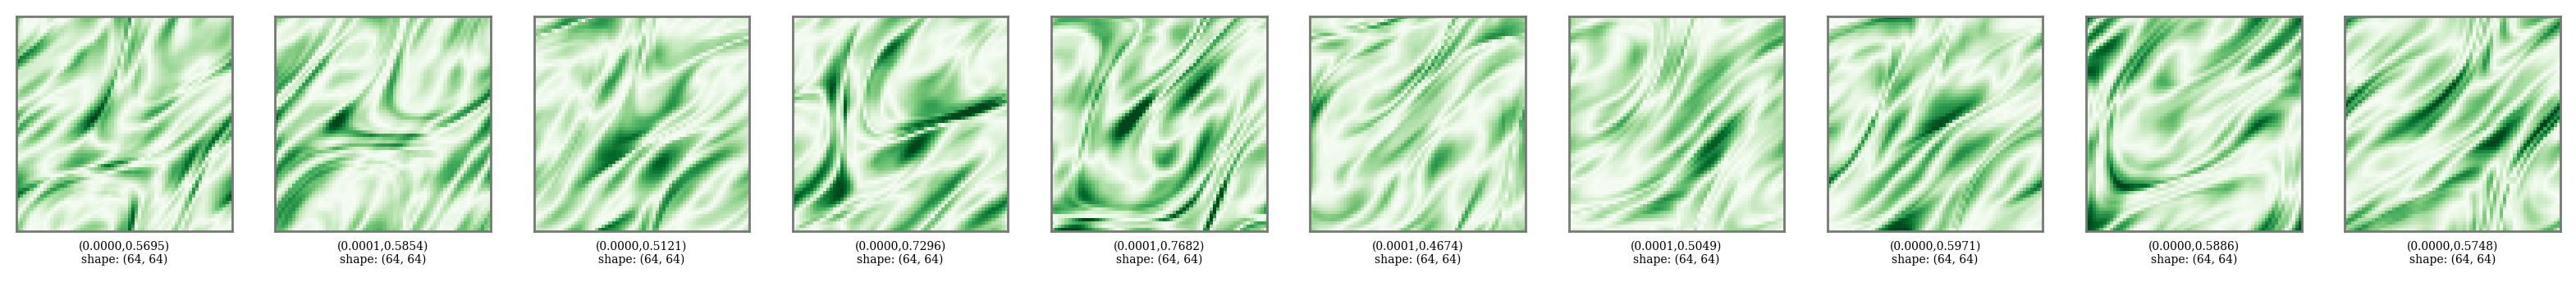


uncertainty_scale:


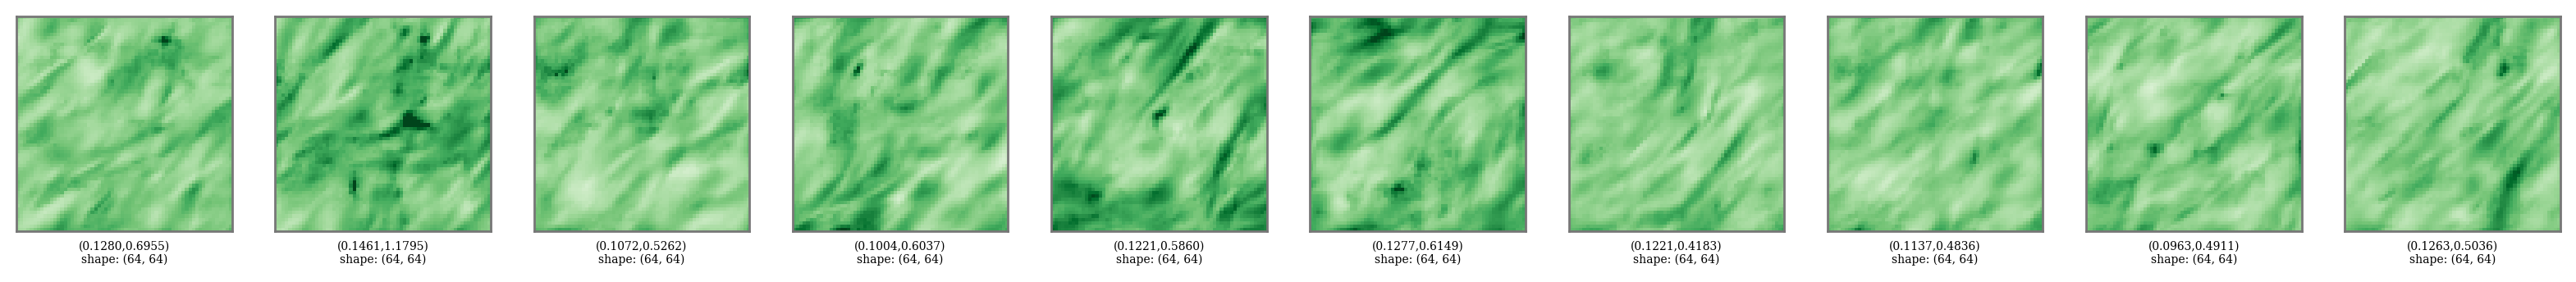

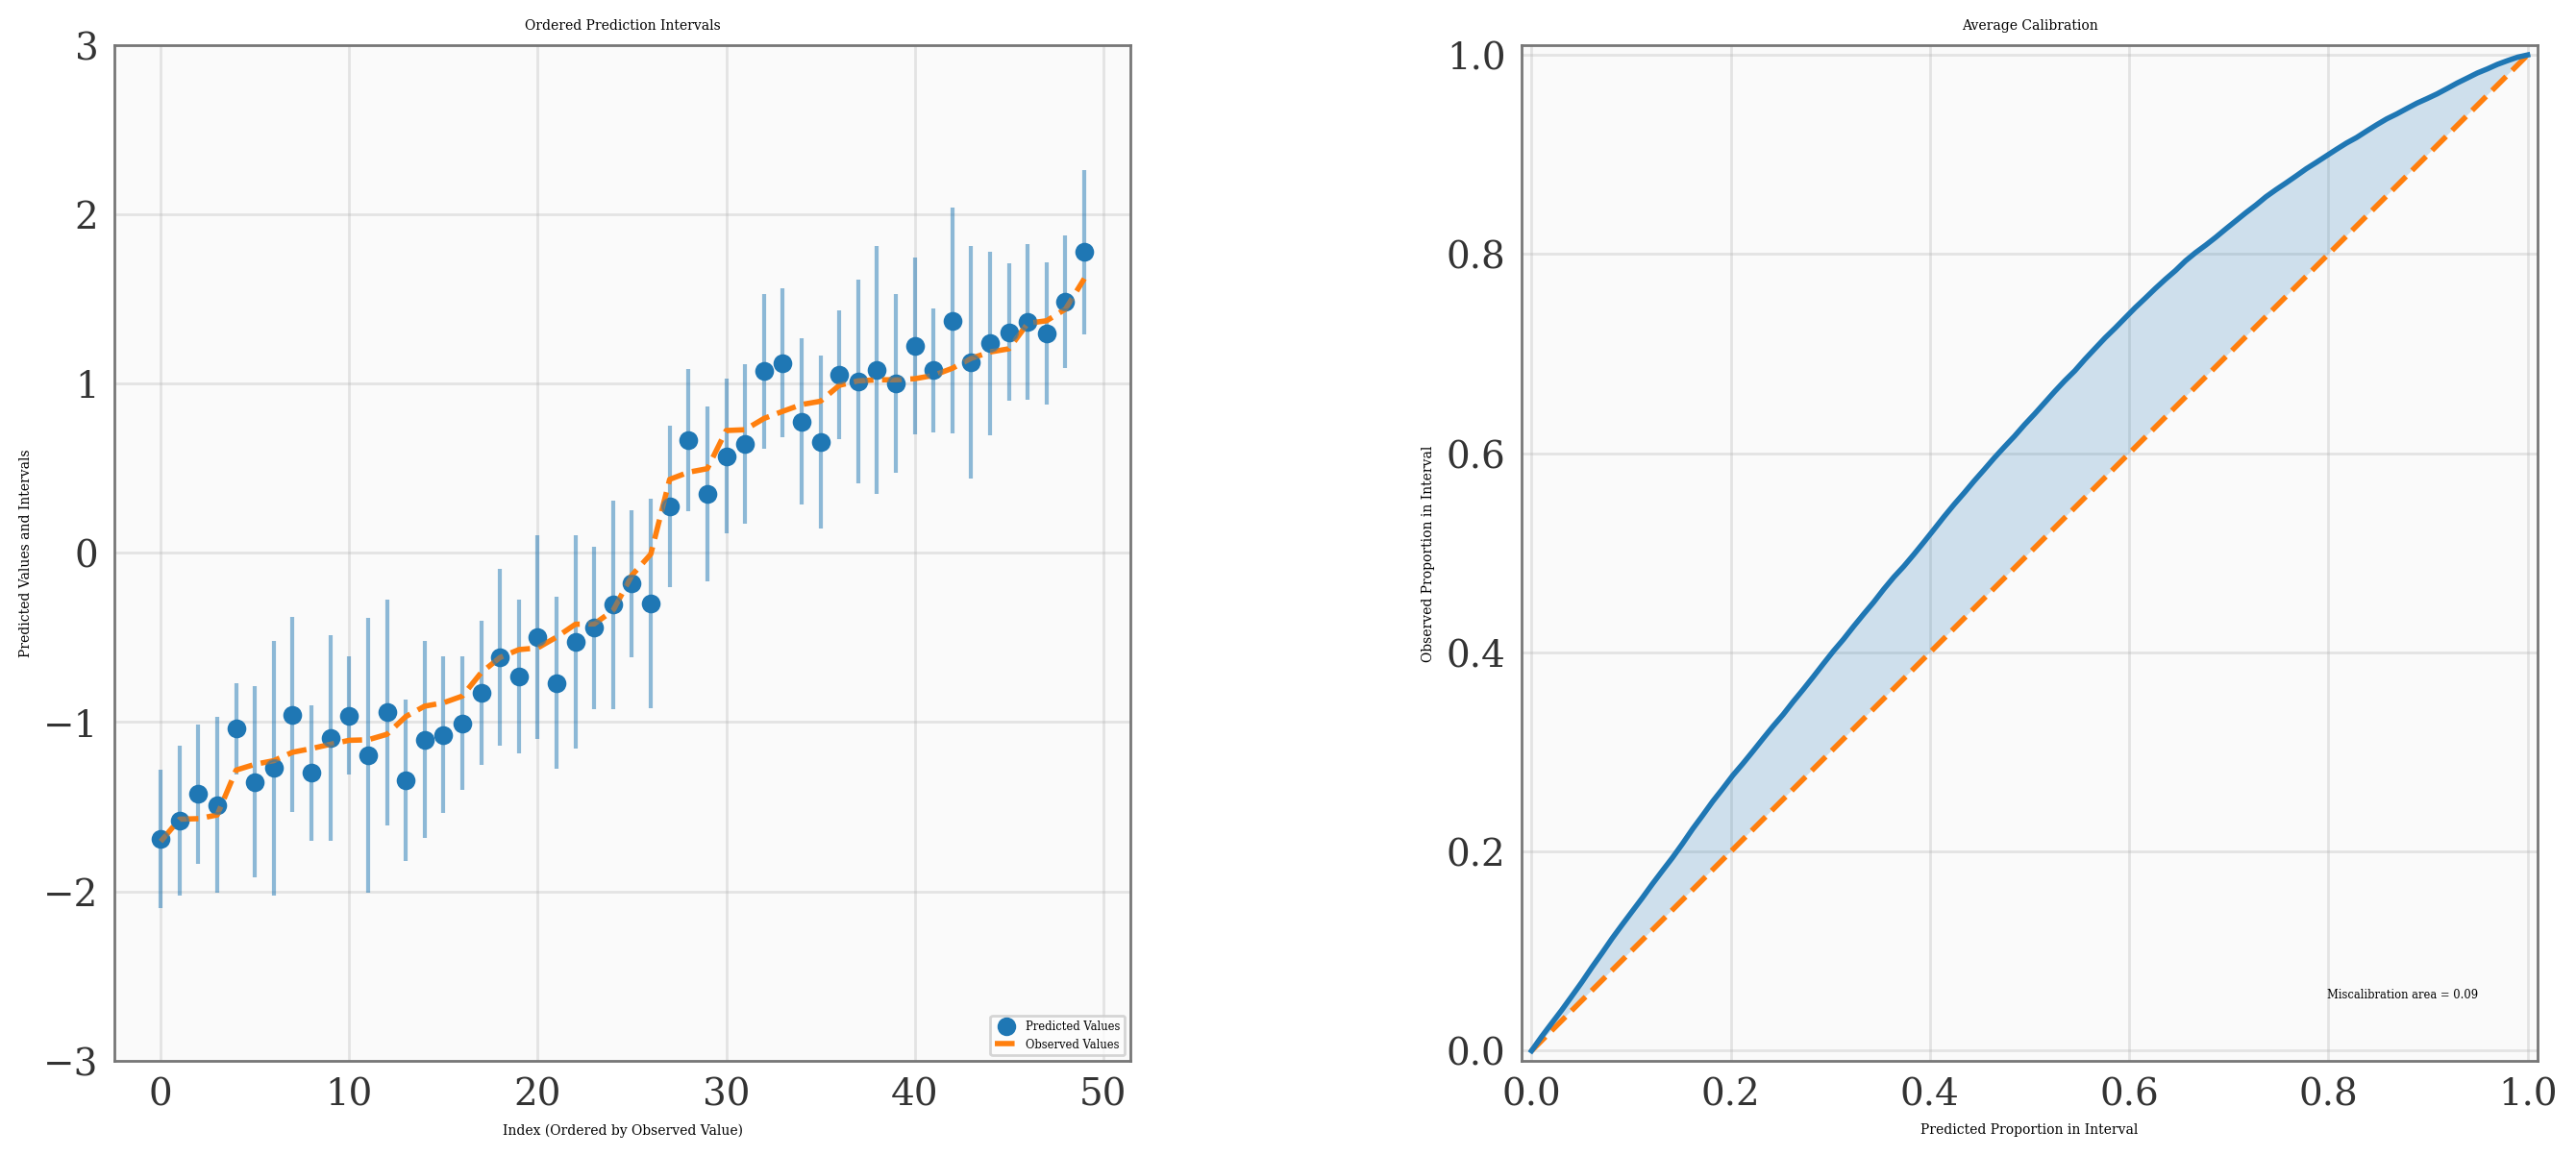

In [69]:
num=10
plot_rollout(init_loc_ensemble, init_scale_full_ensemble, init_gt, idx_list=np.arange(10))

idx: [0 1 2 3 4 5 6 7 8 9]
y:


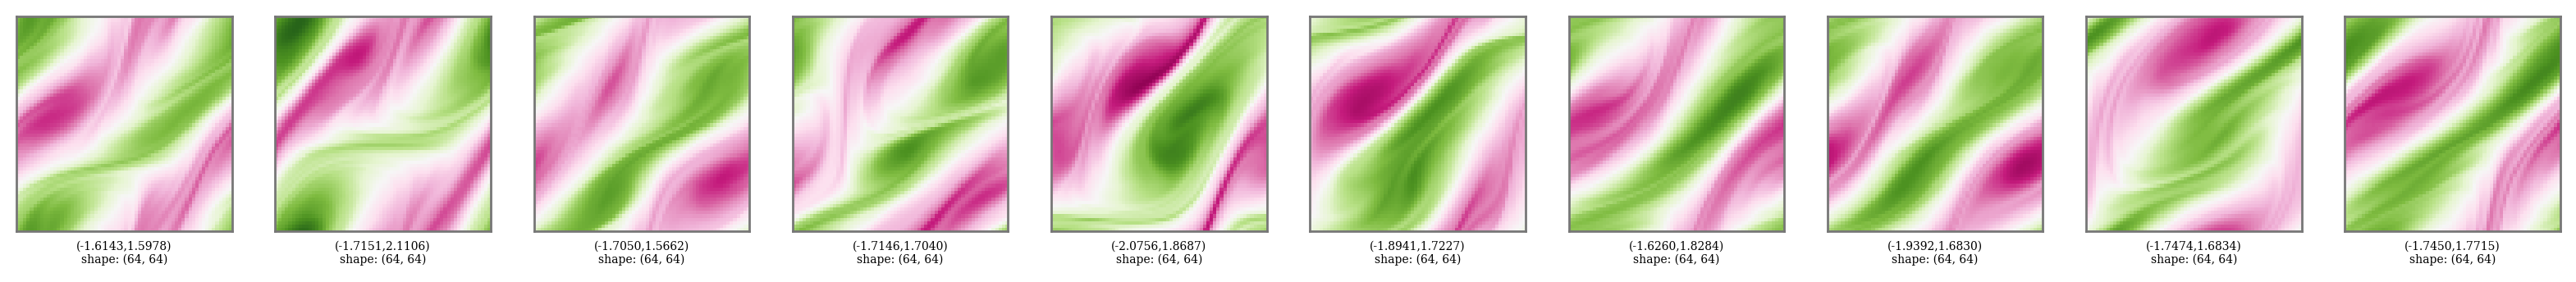


prediction L2=0.191967:


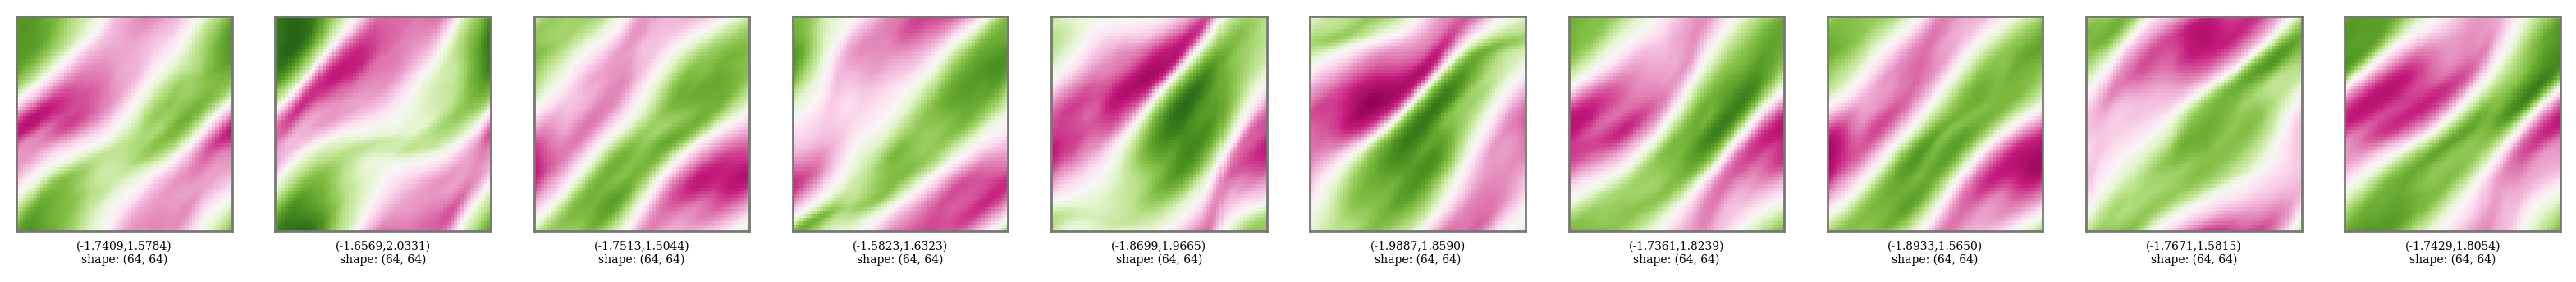


abs error:


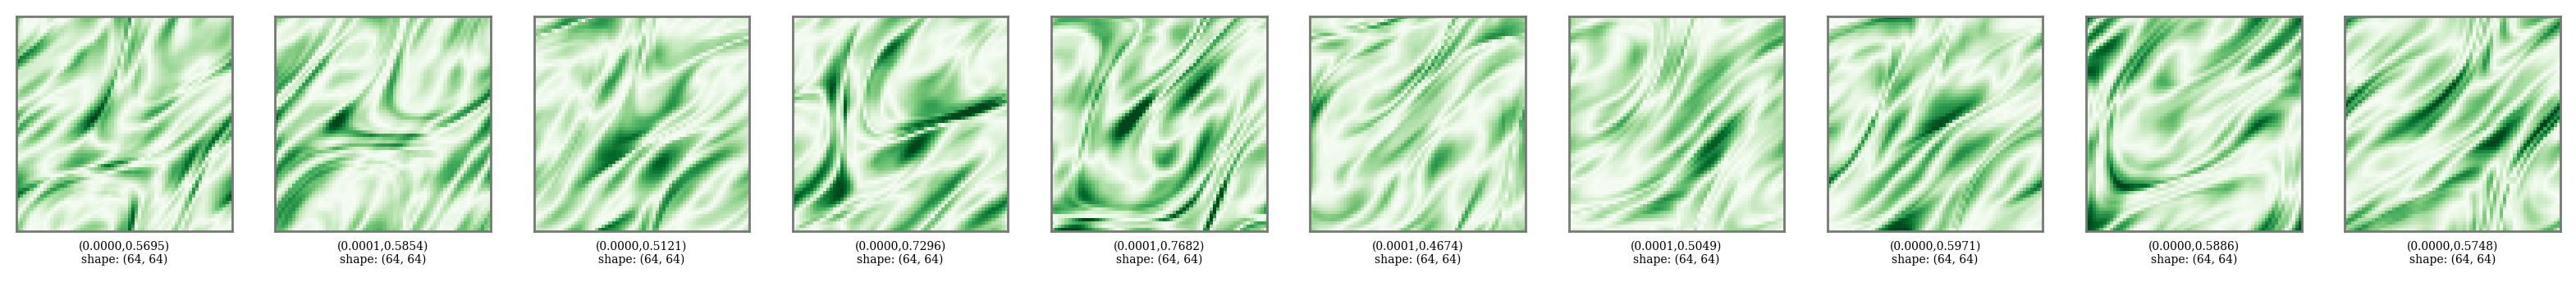


uncertainty_scale:


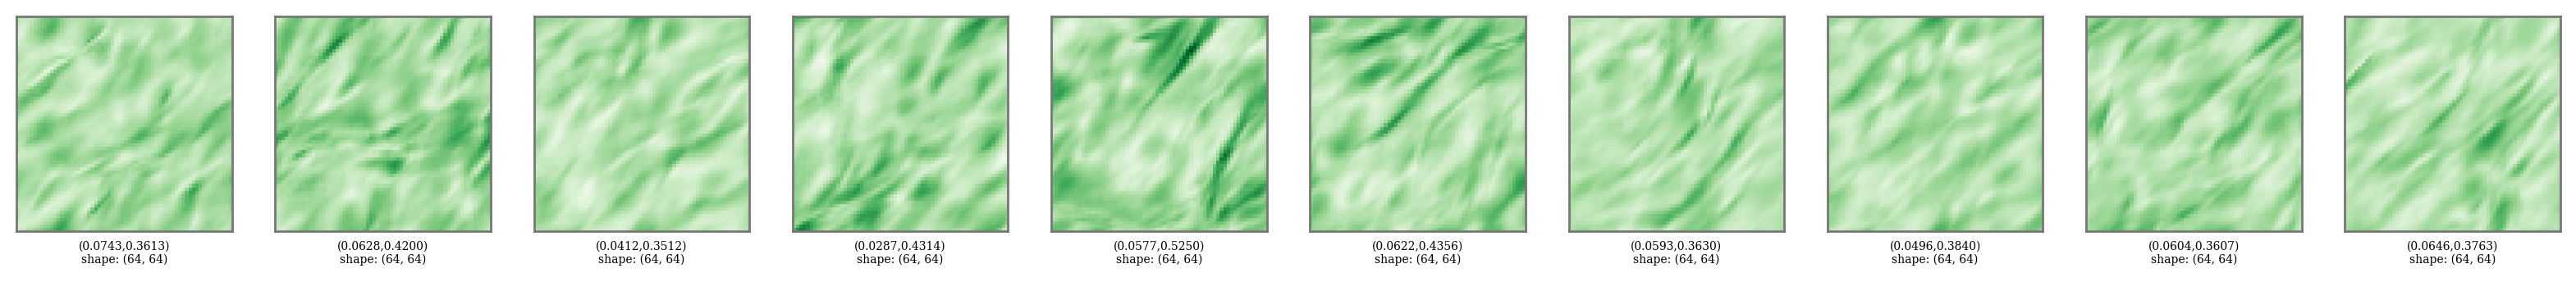

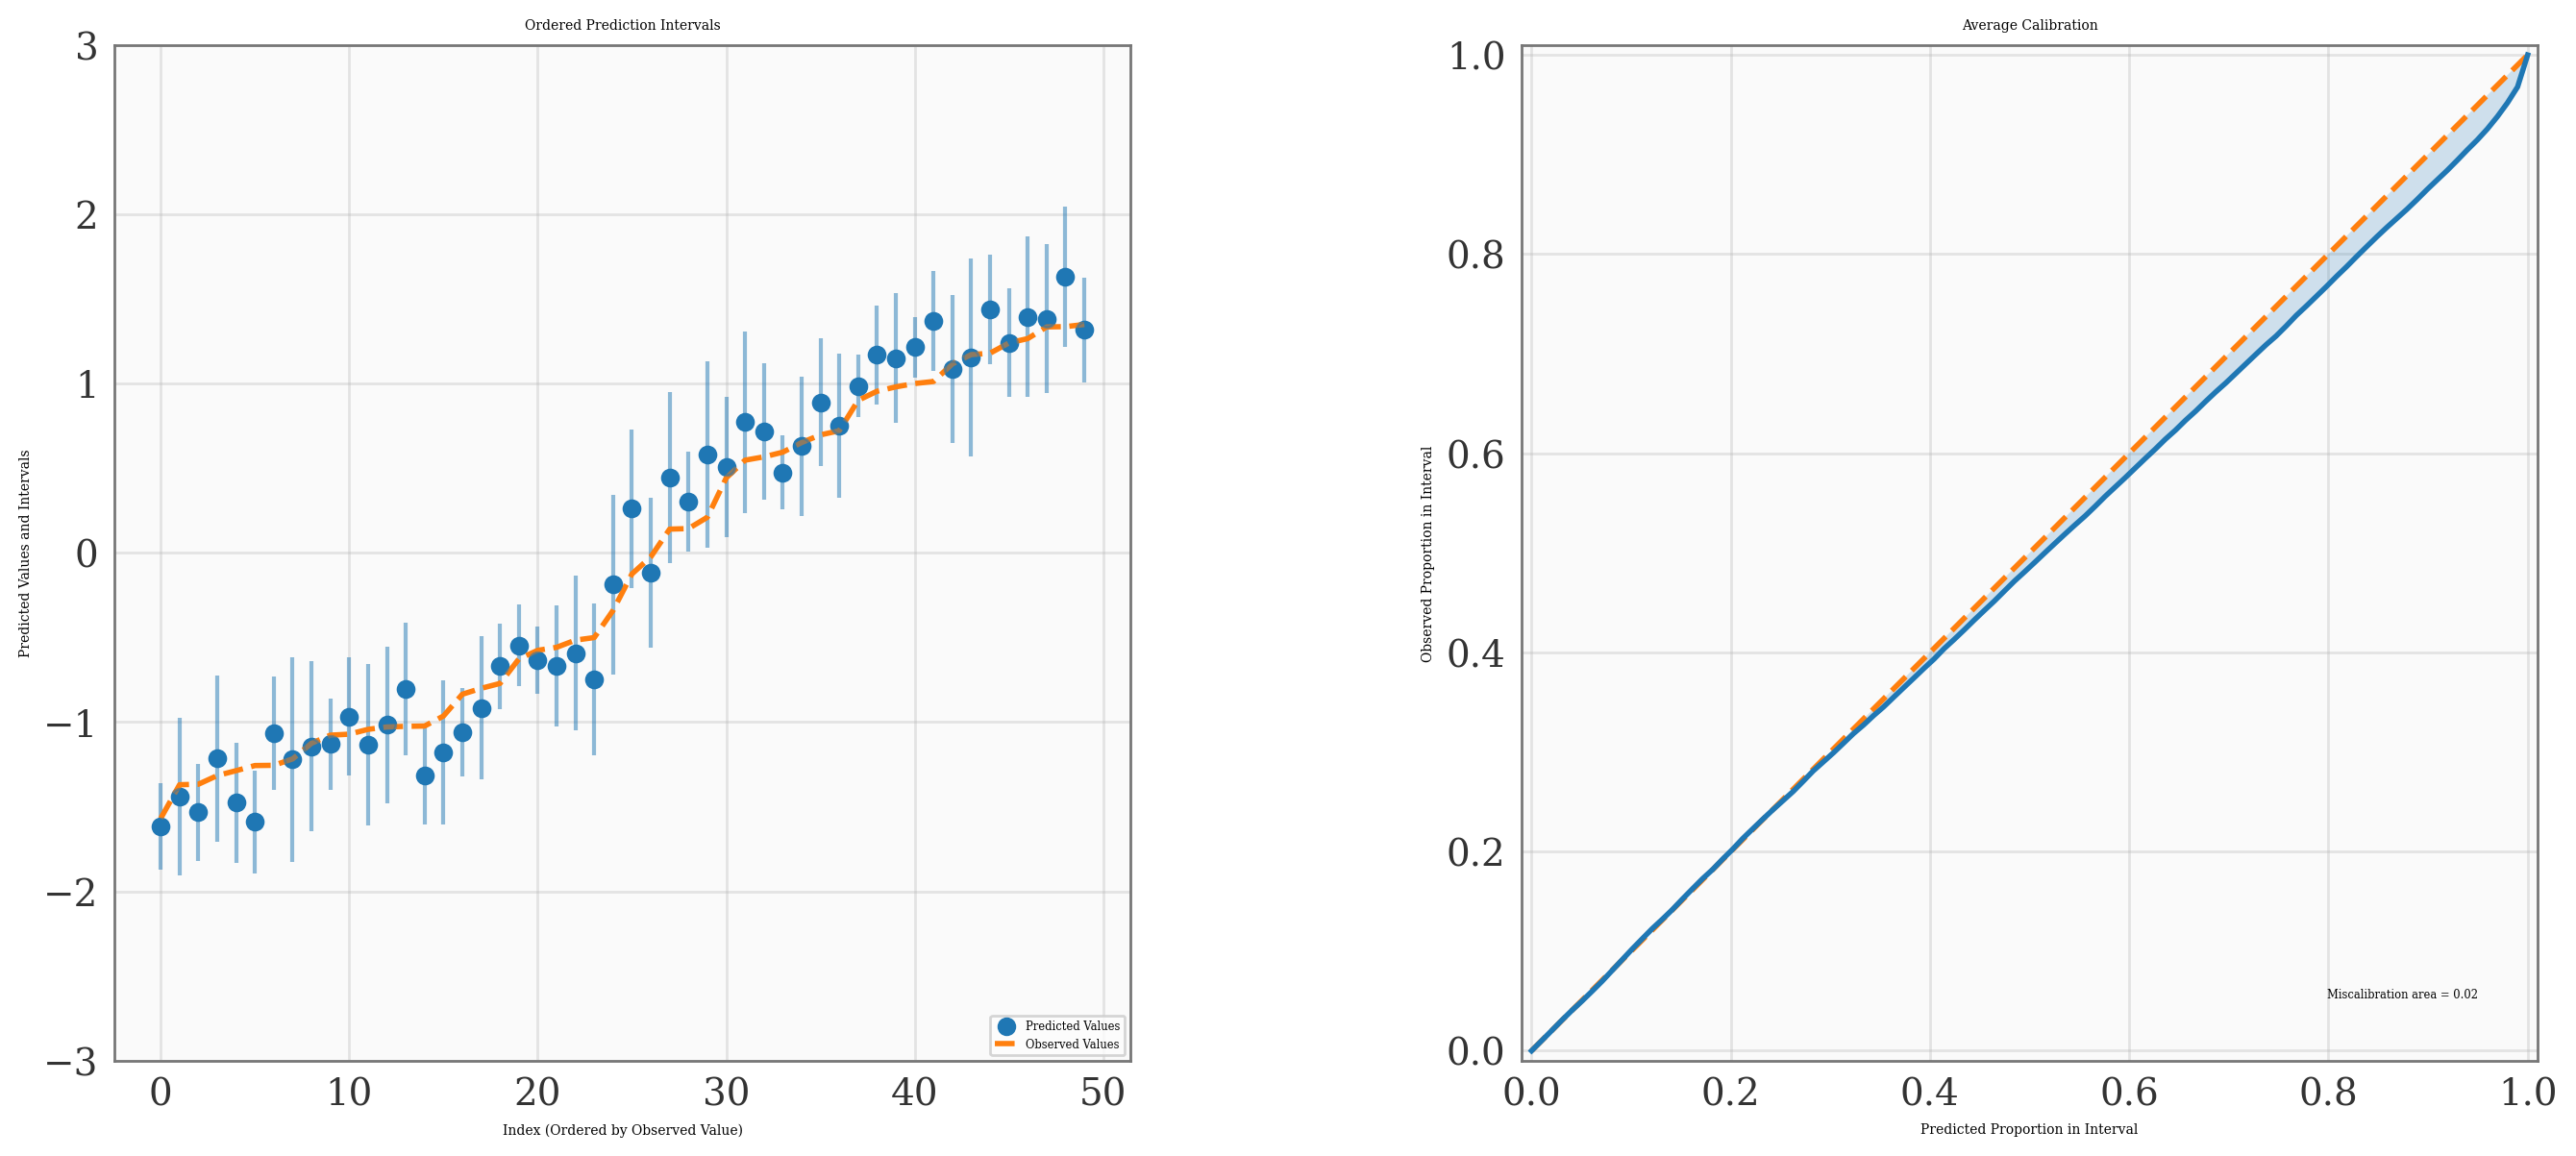

In [71]:
num=10
plot_rollout(init_loc_ensemble, init_scale_det_ensemble, init_gt, idx_list=np.arange(10))